In [ ]:
!pip install pytorch-lightning

In [25]:
import sys
sys.path.append('/content/drive/MyDrive/')
from MboupData import dataset, liverPredict, liverTrain, transform, plot, models

In [26]:
import pytorch_lightning as pl

In [2]:
!cp "/content/drive/MyDrive/ProjetMboup/IMAGES_ECHO_LABELLISEES-20210617T165342Z-001.zip" '.'

In [3]:
!unzip -q IMAGES_ECHO_LABELLISEES-20210617T165342Z-001.zip

In [4]:
!rm IMAGES_ECHO_LABELLISEES-20210617T165342Z-001.zip

In [27]:
path = '/content/IMAGES_ECHO_LABELLISEES/'

In [28]:
transform = transform.TransformData()

In [29]:
data = dataset.LiverDataset(path, transform=transform())

train_dl = data.train_dataloader(batch_size=10, shuffle=False)
test_dl = data.test_dataloader(batch_size=10, shuffle=True)

(96, 96, 3)


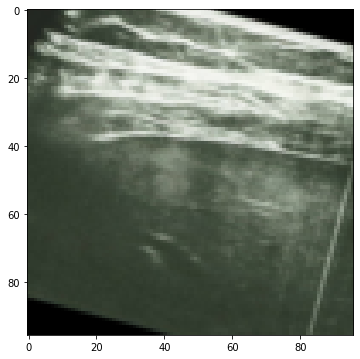

In [30]:
img, label = next(iter(train_dl))
from torchvision import utils
x_grid = utils.make_grid(img[:1], nrow=2, padding = 4)
plot.ShowImage(x_grid).show()

In [31]:
model = models.LiverModel()

In [32]:
import torch
if torch.cuda.is_available()==True:
  model.to(torch.device("cuda:0"))

In [ ]:
trainer = pl.Trainer(gpus=1, max_epochs=100, progress_bar_refresh_rate=20)
trainer.fit(model, train_dl)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:101: UserWarning: you defined a validation_step but have no val_dataloader. Skipping val loop
  rank_zero_warn(f'you defined a {step_name} but have no {loader_name}. Skipping {stage} loop')
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params
------------------------------
0 | net  | VGG  | 134 M 
------------------------------
16.4 K    Trainable params
134 M     Non-trainable params
134 M     Total params
537.108   Total estimated model params size (MB)


In [ ]:
trainer.test(test_dataloaders=test_dl)

In [11]:
train_model = liverTrain.TrainModel(model)

In [12]:
from torch import optim
import torch.nn as nn
# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.Adam(model.parameters(), lr=0.003)

loss_fn = nn.NLLLoss()

In [13]:
xb, yb = next(iter(train_dl))
xb, yb = xb.cuda(), yb.cuda()

x_test, y_test = next(iter(test_dl))
x_test, y_test = x_test.cuda(), y_test.cuda()


train_model.calculate_accuracy(y_test, yb)

0.6000000238418579

In [16]:
train_model.train_batch(xb, yb, loss_fn, optimizer)

(-16.876306533813477, 0.4000000059604645)

In [17]:
train_model.train_epoch(train_dl, test_dl, optimizer, 5, loss_fn)

(-26.521417236328126,
 0.5800000011920929,
 -9.85079517364502,
 0.17000000178813934)

In [21]:
train_model.train_model(200, optimizer, train_dl, test_dl, loss_fn)

Epoch : 0/200, 
                  Training_loss : -210.8019989013672,
                  Train_accuracy : -54.810784912109376,
                  Test_loss : 0.3200000062584877,
                  Test_accuracy : 0.10000000298023223
Epoch : 1/200, 
                  Training_loss : -224.70594177246093,
                  Train_accuracy : -56.68316650390625,
                  Test_loss : 0.3200000062584877,
                  Test_accuracy : 0.14000000059604645
Epoch : 2/200, 
                  Training_loss : -237.15707550048828,
                  Train_accuracy : -63.90589294433594,
                  Test_loss : 0.3200000062584877,
                  Test_accuracy : 0.1
Epoch : 3/200, 
                  Training_loss : -254.00013275146483,
                  Train_accuracy : -69.19481201171875,
                  Test_loss : 0.3200000062584877,
                  Test_accuracy : 0.14000000059604645
Epoch : 4/200, 
                  Training_loss : -274.7492370605469,
                  Train_ac

tensor([[       inf,        inf, 6.7225e+25,        inf],
        [       inf,        inf, 6.8209e+12,        inf],
        [       inf, 1.8259e+31, 1.6436e+09,        inf],
        [       inf,        inf, 9.1935e+19,        inf],
        [       inf,        inf, 5.3690e+28,        inf],
        [       inf,        inf, 6.3241e+17,        inf],
        [       inf, 6.5020e+27, 1.5539e+11,        inf],
        [       inf,        inf, 7.9275e+20,        inf],
        [       inf,        inf, 5.4613e+24,        inf],
        [       inf,        inf, 1.3151e+20,        inf]], device='cuda:0')
0 0
(96, 96, 3)


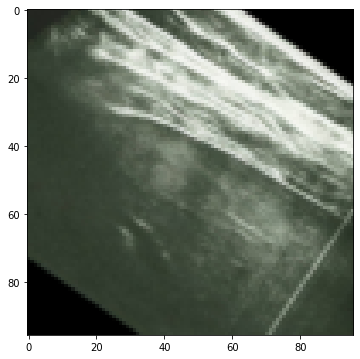

In [19]:
liverPredict.Predict(test_dl, model).afficher(4)

In [20]:
optimizer.zero_grad()
im,labe = next(iter(train_dl))
if torch.cuda.is_available()==True:
  im = im.type(torch.float).to(torch.device("cuda:0"))
  
  labe_pred = torch.exp(model(im))
  print(labe_pred.topk(1))

torch.return_types.topk(
values=tensor([[inf],
        [inf],
        [inf],
        [inf],
        [inf],
        [inf],
        [inf],
        [inf],
        [inf],
        [inf]], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0'))


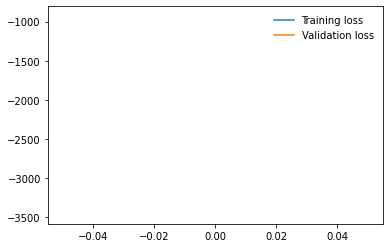

In [24]:
import matplotlib.pyplot as plt
train_losses, train_acc, test_losses, test_acc = train_model.train_epoch(train_dl, test_dl, optimizer, 5, loss_fn)
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)